In [220]:
# dependencies and libraries
#%load_ext lab_black
import sqlite3
import io
import pandas as pd
import numpy as np
from collections import defaultdict
from pathlib import Path
from decimal import Decimal
from scipy.stats import wasserstein_distance, entropy
import matplotlib.pyplot as plt
from collections import defaultdict
import math, heapq
import timeit

%matplotlib inline

In [221]:
conn = sqlite3.connect("SeeDb.db")
cursor = conn.cursor()
agg_funcs = ["avg", "sum", "count", "min", "max"]
dimensions = [
    "sex",
    "work_class",
    "education",
    "occupation",
    #"relationship",
    "race",
    "native_country",
    "class",
]  # marital_status should not be included
measures = [
    "age",
    # "fnlwgt",
    "education_num",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
]
epsilon = Decimal(1e-8)
n_partitions = 10
S_row = 10000

In [222]:
# this cell has the functions definitions responsible to create, fill and query the database
# run this cell once whenever the notebook is disconnected to create the database and fill it locally
def create_fill_database():
    # Drop table if it exists
    cursor.execute("""DROP TABLE IF EXISTS census""")
    # Create table
    cursor.execute(
        """CREATE TABLE census
                (age int, work_class text, fnlwgt int, education text, education_num int, marital_status text, occupation text, relationship text, 
                race text, sex text, capital_gain int, capital_loss int, hours_per_week int, native_country text, class text)"""
    )

    # fill the database
    df = pd.DataFrame(pd.read_csv("adultdata.csv"))
    for row in df.itertuples():
        cursor.execute(
            """
                  INSERT INTO census (age, work_class, fnlwgt, education, education_num, marital_status, occupation, relationship, 
                  race, sex, capital_gain, capital_loss, hours_per_week, native_country, class)
                  VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
                  """,
            (
                row.AGE,
                row.WORK_CLASS,
                row.FNLWGT,
                row.EDUCATION,
                row.EDUCATION_NUM,
                row.MARITAL_STATUS,
                row.OCCUPATION,
                row.RELATIONSHIP,
                row.RACE,
                row.SEX,
                row.CAPITAL_GAIN,
                row.CAPITAL_LOSS,
                row.HOURS_PER_WEEK,
                row.NATIVE_COUNTRY,
                row.CLASS,
            ),
        )
    conn.commit()
    # conn.close()


# create_fill_database()

## Phase-based Execution Framework:

In [223]:
def exec_view(view):
    """
    Returns the result of running the view query for target and reference"""
    group_by, measurement, agg_func = view
    target_query = "select {0}, {1}({2}) from census where marital_status in ('Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent') Group By {0};".format(
        group_by, agg_func, measurement
    )
    ref_query = "select {0}, {1}({2}) from census where marital_status in ('Never-married', 'Widowed','Divorced', 'Separated') Group By {0};".format(
        group_by, agg_func, measurement
    )
    target_df = execute_query(target_query)
    ref_df = execute_query(ref_query)
    return target_df, ref_df


def execute_query(query):
    """Returns a dataframe object with all the resulting records
    Arguments:
      query: The query to execute"""
    records_df = pd.read_sql_query(query, conn)
    return records_df


def partition_DB(n):
    """Returns a list of each partition starting point and a -1 at the end
    Arguments:
      n: number of partitions
    """
    records_count = execute_query("select count(*) from census").iloc[0]
    partition_size = int(records_count / n)
    range_starts = []
    for i in range(n):
        range_starts.append(i * partition_size)
    range_starts.append(-1)
    return range_starts


def run_query_on_partition(query, start, end=-1):
    """Execute query on dataset partition
    Arguments:
      query: query to execute
      start: start of the dataset partition (not inclusive)
      end: end of the dataset partition (inclusive) (default -1 for the last partition)
    Returns:
      Dataframe containing result of executing the query on the dataset partition
    """
    part1 = query
    part2 = ""
    idx = query.lower().find("group by")
    if idx != -1:
        part1 = query[:idx]
        part2 = query[idx:]
    # add the partitioning condition to the where clause
    if "where" in part1.lower():
        part1 += " AND rowid > " + str(start)
    else:
        part1 += " where rowid > " + str(start)
    # the last partition doesn't have an end condition
    if end != -1:
        part1 += " AND rowid <= " + str(end)

    return execute_query(part1 + " " + part2)


print("Partitioning output on census database: ")
print(partition_DB(n_partitions))
print("run_query_on_partition output: ")
display(run_query_on_partition("select * from census", 0, 10))

Partitioning output on census database: 
[0, 3016, 6032, 9048, 12064, 15080, 18096, 21112, 24128, 27144, -1]
run_query_on_partition output: 


,age,work_class,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


## Sharing-based Optimizations:

Implementation of First-Fit Decreasing Algorithm:

In [205]:
# TODO: we have to try out different values of S_row using a grid search to see which runs faster compared to when we don't combine group-by attributes

In [224]:
def get_all_views():
    """Returns all possible a * m * f views"""
    views = []
    for f in agg_funcs:
        for a in dimensions:
            for m in measures:
                views.append((a, m, f))
    return views


v = get_all_views()
print("Total number of views: {}. Sample view: {}".format(len(v), v[10]))

Total number of views: 175. Sample view: ('education', 'age', 'avg')


In [225]:
def get_views_with_same_group_by(views):
    """Returns a dictionary, the key is the group by attribute and the value is the view tuple"""
    d = defaultdict(list)

    for view in views:
        (a, m, f) = view
        d[a].append(view)
    return d


# print(len(get_views_with_same_group_by(get_all_views())))


def get_all_combined_queries(views):
    """Returns a list of all possible queries to be applied after applying the shared-based optimization
    Arguments:
        views: list of tuples in the form (a, m, f)"""
    queries = []

    # Combine Multiple Aggregates
    v = get_views_with_same_group_by(views)
    for group_by_str, tuples in v.items():
        measures = defaultdict(set)
        measures_str = []
        for (a, m, f) in tuples:
            measures[f].add(m)
            if m in measures["avg"]:
                measures["count"].add(m)
        for f in measures:
            for m in measures[f]:
                measures_str.append("{0}({1}) as {0}_{1}".format(f, m))
        combined_measures_str = ", ".join(measures_str)
        # Combine reference and target queries
        ref_target_string = """, CASE WHEN marital_status in ('Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent') THEN 'Married' ELSE 'Unmarried' END grouped_marital_status"""
        combined_measures_str += ref_target_string

        queries.append(
            "SELECT {1}, {0} FROM census GROUP BY {1}, grouped_marital_status;".format(
                combined_measures_str, group_by_str
            )
        )
    return queries


# Test
all_views = get_all_views()
for i in range(len(dimensions)):
    print(get_all_combined_queries(all_views)[i])

SELECT sex, avg(age) as avg_age, avg(capital_loss) as avg_capital_loss, avg(capital_gain) as avg_capital_gain, avg(hours_per_week) as avg_hours_per_week, avg(education_num) as avg_education_num, count(age) as count_age, count(capital_loss) as count_capital_loss, count(capital_gain) as count_capital_gain, count(hours_per_week) as count_hours_per_week, count(education_num) as count_education_num, sum(age) as sum_age, sum(capital_loss) as sum_capital_loss, sum(capital_gain) as sum_capital_gain, sum(hours_per_week) as sum_hours_per_week, sum(education_num) as sum_education_num, min(age) as min_age, min(capital_loss) as min_capital_loss, min(capital_gain) as min_capital_gain, min(hours_per_week) as min_hours_per_week, min(education_num) as min_education_num, max(age) as max_age, max(capital_loss) as max_capital_loss, max(capital_gain) as max_capital_gain, max(hours_per_week) as max_hours_per_week, max(education_num) as max_education_num, CASE WHEN marital_status in ('Married-AF-spouse', 'Ma

In [226]:
import operator


class Bin:
    def __init__(self, c):
        self.items = []
        self.remaining_cap = c

    def add(self, dimension, weight):
        self.items.append(dimension)
        self.remaining_cap -= weight

    def get_dimensions(self):
        return self.items

    def get_cap(self):
        return self.remaining_cap


def first_fit(dimensions, c):
    bins = []
    # add first bin
    bins.append(Bin(c))
    for dimension, weight in dimensions:
        need_new_bin = True
        for bin in bins:
            if bin.get_cap() >= weight:
                bin.add(dimension, weight)
                need_new_bin = False
                break
        if need_new_bin:
            bins.append(Bin(c))
            bins[-1].add(dimension, weight)

    return [b.get_dimensions() for b in bins]


def first_fit_dec(dimensions, c):
    sorted_dims = sorted(dimensions.items(), key=operator.itemgetter(1), reverse=True)
    return first_fit(sorted_dims, c)


def get_distinct_dimension_counts_log10():
    count_str = []
    for d in dimensions:
        count_str.append("count(distinct {0}) as {0}".format(d))
    count_str = ", ".join(count_str)
    query = "SELECT {} FROM census".format(count_str)
    output = execute_query(query)
    log_values = np.log10(
        np.array(output)[0]
    )  # because the output is [[2, 7, 16, 7, 14, 6, 5, 41, 2]]
    column_names = output.columns
    return dict(zip(column_names, log_values))


# Test first_fit_dec

dist_dimension_count_log10s = get_distinct_dimension_counts_log10()
print(
    "The groups of dimension attributes that we need to combine in GROUP BYs if we have all attributes appearing in views tuples: {}".format(
        first_fit_dec(dist_dimension_count_log10s, np.log10(S_row))
    )
)

The groups of dimension attributes that we need to combine in GROUP BYs if we have all attributes appearing in views tuples: [['native_country', 'education', 'occupation'], ['work_class', 'race', 'sex', 'class']]


In [227]:
def get_all_combined_queries_with_multiple_group_by(views, dist_dimension_count_log10s):
    # it takes queries after applying the multiple aggregate and target and reference combining
    """Returns a list of all possible queries to be applied after applying the shared-based optimization
    Arguments:
        views: list of tuples in the form (a, m, f)"""

    views_dict = get_views_with_same_group_by(views)
    all_dimensions = dist_dimension_count_log10s.keys()
    bin_sizes = dist_dimension_count_log10s.copy()
    for dimension in all_dimensions:
        if dimension not in views_dict.keys():
            bin_sizes.pop(dimension)
    # dist_dimension_count_log10s holds all the bin sizes for the set of dimension attributes that appear in 'views' tuples

    combined_dimensions_list = first_fit_dec(bin_sizes, np.log10(S_row))

    queries = []

    for combined_dimensions in combined_dimensions_list:
        measures = defaultdict(set)
        measures_str = []
        for dimension in combined_dimensions:
            tuples = views_dict[dimension]
            for (a, m, f) in tuples:
                measures[f].add(m)
                if m in measures["avg"]:
                    measures["count"].add(m)
        for f in measures:
            for m in measures[f]:
                measures_str.append("{0}({1}) as {0}_{1}".format(f, m))
        combined_measures_str = ", ".join(measures_str)
        # Combine reference and target queries
        ref_target_string = """, CASE WHEN marital_status in ('Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent') THEN 'Married' ELSE 'Unmarried' END grouped_marital_status"""
        combined_measures_str += ref_target_string
        group_by_str = ", ".join(combined_dimensions)
        queries.append(
            "SELECT {1}, {0} FROM census GROUP BY {1}, grouped_marital_status;".format(
                combined_measures_str, group_by_str
            )
        )
    return queries


# Test
all_views = get_all_views()
queries = get_all_combined_queries_with_multiple_group_by(
    all_views, dist_dimension_count_log10s
)
for q in queries:
    print(q)

SELECT native_country, education, occupation, avg(age) as avg_age, avg(capital_loss) as avg_capital_loss, avg(capital_gain) as avg_capital_gain, avg(hours_per_week) as avg_hours_per_week, avg(education_num) as avg_education_num, count(age) as count_age, count(capital_loss) as count_capital_loss, count(capital_gain) as count_capital_gain, count(hours_per_week) as count_hours_per_week, count(education_num) as count_education_num, sum(age) as sum_age, sum(capital_loss) as sum_capital_loss, sum(capital_gain) as sum_capital_gain, sum(hours_per_week) as sum_hours_per_week, sum(education_num) as sum_education_num, min(age) as min_age, min(capital_loss) as min_capital_loss, min(capital_gain) as min_capital_gain, min(hours_per_week) as min_hours_per_week, min(education_num) as min_education_num, max(age) as max_age, max(capital_loss) as max_capital_loss, max(capital_gain) as max_capital_gain, max(hours_per_week) as max_hours_per_week, max(education_num) as max_education_num, CASE WHEN marital_s

In [228]:
def execute_combined_queries_on_partition(combined_queries, part_start, part_end):
    results = []
    for query in combined_queries:
        result_df = run_query_on_partition(query, part_start, part_end)
        results.append(result_df)
    return results

### **Pruning based optimization**

Calculate utilities for combined GROUP-BYs:

In [229]:
def kl_divergence(target_agg_vals, ref_agg_vals):
    # normalize
    target_agg_vals = np.array(target_agg_vals, dtype=float)
    ref_agg_vals = np.array(ref_agg_vals, dtype=float)
    t_sum = sum(target_agg_vals)
    r_sum = sum(ref_agg_vals)
    t_norm = [i / t_sum for i in target_agg_vals]
    r_norm = [i / r_sum for i in ref_agg_vals]
    # calculate divergence
    return entropy(t_norm, r_norm)


def calculate_utility(target_agg_vals, ref_agg_vals):
    # Earth Mover's Distance
    # return wasserstein_distance(target_agg_vals, ref_agg_vals)
    # KL Divergence
    return kl_divergence(target_agg_vals, ref_agg_vals)


def get_target_and_ref_aggregated_fms(aggregated_fms):
    # Now we make sure the same values for dimension attributes exist in the mapping for both target and reference.
    # Then, we can return the list of aggregate function values corresponding to those dimension values to be used for calculating utility.
    target_fms = aggregated_fms[0]
    ref_fms = aggregated_fms[1]
    dim_agg_pairs = defaultdict(list)
    target_agg_vals = []
    ref_agg_vals = []

    for dimension_val, agg_val in target_fms.items():
        if agg_val == 0:
            temp = epsilon
        else:
            temp = agg_val
        dim_agg_pairs[dimension_val].append(temp)

    for dimension_val, agg_val in ref_fms.items():
        if dimension_val not in dim_agg_pairs:  # dim_val in ref but not in target
            dim_agg_pairs[dimension_val].append(epsilon)

        if agg_val == 0:
            temp = epsilon
        else:
            temp = agg_val
        dim_agg_pairs[dimension_val].append(temp)

    for dim_val, agg_vals in dim_agg_pairs.items():
        if len(agg_vals) < 2:  # dim_val in target but not in ref
            dim_agg_pairs[dim_val].append(epsilon)

    for agg_vals in dim_agg_pairs.values():
        target_agg_vals.append(agg_vals[0])
        ref_agg_vals.append(agg_vals[1])

    return target_agg_vals, ref_agg_vals


def calculate_dimension_avg(fm_values, count_ms):
    agg_val_sum = 0
    count_sum = 0
    for fm, count in zip(fm_values, count_ms):
        count_sum += count
        agg_val_sum += fm * count
    if count_sum != 0:
        return agg_val_sum / count_sum
    else:
        return epsilon


def calculate_aggregate_value(dim_val, fm_values, agg_func, result, m, a):
    if agg_func == "avg":
        count_ms = list(
            result[result[a] == dim_val]["count_{}".format(m)]
        )  # count(m) for the corresponding row
        return calculate_dimension_avg(count_ms, fm_values)
    elif agg_func == "min":
        return min(fm_values)
    elif agg_func == "max":
        return max(fm_values)
    elif agg_func == "sum":
        return sum(fm_values)
    elif agg_func == "count":
        return sum(fm_values)
    else:
        raise ValueError(
            "Aggregate function cannot be {} for dimension value {}!".format(
                agg_func, dim_val
            )
        )


def calc_utilities(results, views=get_all_views()):
    utilities = {}
    aggregated_fms = [defaultdict(list), defaultdict(list)]
    for (a, m, f) in views:
        for i in range(len(results)):  # for target and reference results
            result = results[i]
            for dim_val in result[a].unique():  # for every value of a dimension
                # if dim_val == '?':
                #     continue
                fm_values = list(
                    result[result[a] == dim_val]["{}_{}".format(f, m)]
                )  # get all of corresponding f(m) values
                aggregated_fms[i][dim_val] = calculate_aggregate_value(
                    dim_val, fm_values, f, result, m, a
                )
                target_agg_vals, ref_agg_vals = get_target_and_ref_aggregated_fms(
                    aggregated_fms
                )
        utilities[(a, m, f)] = calculate_utility(target_agg_vals, ref_agg_vals)
    return utilities


def calc_utilities_given_views(
    target_results, reference_results, views=get_all_views()
):
    utilities = {}
    aggregated_fms = [defaultdict(list), defaultdict(list)]
    all_query_results = [target_results, reference_results]
    for (a, m, f) in views:
        for i in range(len(all_query_results)):  # for target and reference results
            result = None
            for query_results in all_query_results[i]:
                if set((a, "{}_{}".format(f, m))).issubset(query_results.columns):
                    result = query_results

            for dim_val in result[a].unique():  # for every value of a dimension
                # if dim_val == '?':
                #     continue
                fm_values = list(
                    result[result[a] == dim_val]["{}_{}".format(f, m)]
                )  # get all of corresponding f(m) values
                aggregated_fms[i][dim_val] = calculate_aggregate_value(
                    dim_val, fm_values, f, result, m, a
                )
                target_agg_vals, ref_agg_vals = get_target_and_ref_aggregated_fms(
                    aggregated_fms
                )
        utilities[(a, m, f)] = calculate_utility(target_agg_vals, ref_agg_vals)
    return utilities


# view_utilities = calc_utilities(results[0:2]) # we should change here Hadeel
# view_utilities

In [230]:
def Hoeffding_Serfling_Error(m, N, delta=10**-2):
    return math.sqrt(
        (1 - (m - 1) / N)
        * (2 * math.log(math.log(m)) + math.log(math.pi**2 / (3 * delta)))
        / (2 * m)
    )

In [231]:
def confidence_interval_pruning(upperbound, lowerbound, optimized_queries, k):
    top_k_queries = set(heapq.nlargest(k, upperbound, key=upperbound.get))
    top_k_lowest_lowerbound = min(lowerbound[q] for q in top_k_queries)
    for query in optimized_queries:
        if query not in top_k_queries:
            if upperbound[query] < top_k_lowest_lowerbound:
                optimized_queries.remove(query)
    return optimized_queries

In [232]:
def MAB_pruning(current_mean, optimized_queries, k):
    top_k_1 = heapq.nlargest(k + 1, current_mean, key=current_mean.get)
    sorted_queries = sorted(
        list(optimized_queries), key=lambda q: current_mean[q], reverse=True
    )
    lowest = min(current_mean[q] for q in current_mean)
    delta_1 = top_k_1[0][1] - top_k_1[k - 1][1]
    delta_n = top_k_1[-1][1] - lowest
    if delta_1 > delta_n:
        sorted_queries.pop(0)
    else:
        sorted_queries.pop(-1)
    return set(sorted_queries)

In [260]:
def prune_views(m, top_views, running_mean, prune_method="CI", N=n_partitions, k=5):

    # print("prune started")
    if m == 1:
        return top_views
    if prune_method == "CI":
        upperbounds, lowerbounds = {}, {}
        confidence_interval = Hoeffding_Serfling_Error(m, N)
        for q in top_views:
            upperbounds[q] = running_mean[q] + confidence_interval
            lowerbounds[q] = running_mean[q] - confidence_interval
        return confidence_interval_pruning(upperbounds, lowerbounds, top_views, k)
    elif prune_method == "MAB":
        return MAB_pruning(running_mean, top_views, k)
    else:
        return top_views

### **Visualizing top k queries:**

In [234]:
def get_top_k_views(view_utilities, k):
    return sorted(view_utilities.items(), key=lambda item: item[1], reverse=True)[:k]


# get_top_k_views(view_utilities, 10)

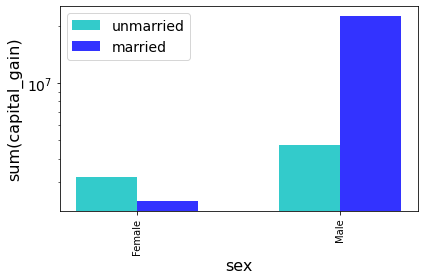

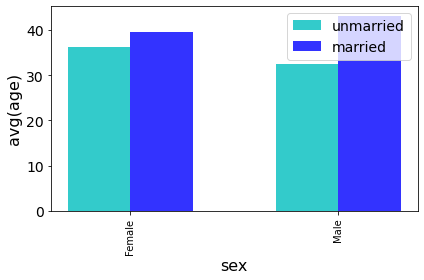

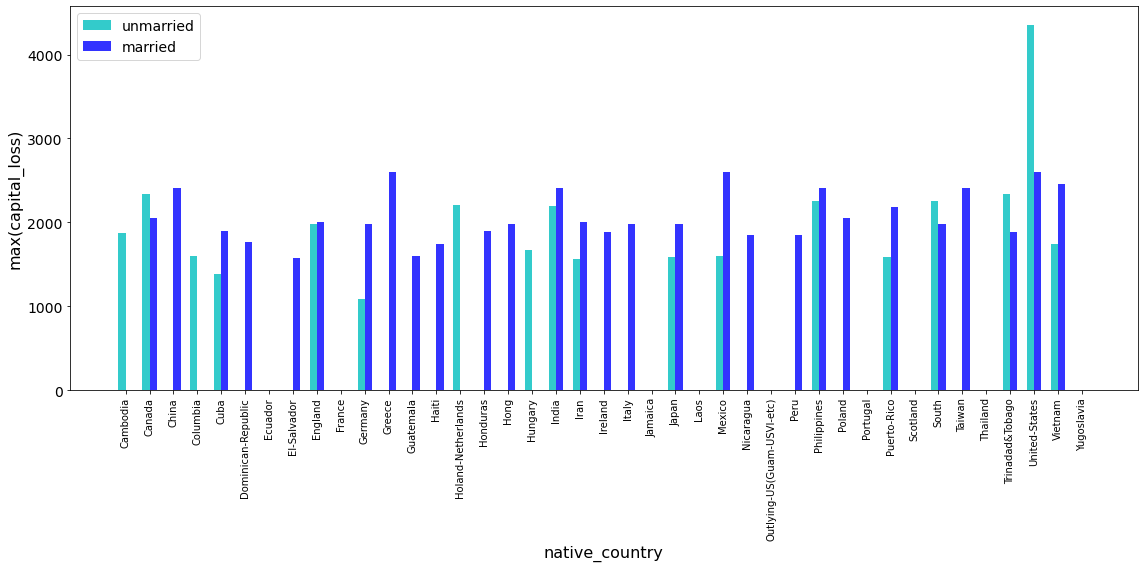

In [276]:
# This list is used only for testing, it should be removed
views_list = [
    ("sex", "capital_gain", "sum"),
    ("sex", "age", "avg"),
    ("native_country", "capital_loss", "max")
]

#plt.rcParams["figure.figsize"] = (20, 8)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=14)


def draw_views(views_list):
    for view in views_list:
        group_by, measurement, agg_func = view
        # if group_by == "marital_status":
        #     query = """select CASE WHEN marital_status in ('Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent') THEN 'Married' ELSE 'Unmarried' END grouped_marital_status
        #     , {}({}) from census Group by grouped_marital_status;""".format(
        #         agg_func, measurement
        #     )
        #     group_by = "grouped_marital_status"
        #     res = execute_query(query)
        #     target_df = res.loc[res["grouped_marital_status"] == "Married"].reset_index(
        #         drop=True
        #     )
        #     ref_df = res.loc[res["grouped_marital_status"] == "Unmarried"].reset_index(
        #         drop=True
        #     )

        # else:
        target_query = "select {0}, {1}({2}) from census where marital_status in ('Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent') Group By {0};".format(
            group_by, agg_func, measurement
        )
        ref_query = "select {0}, {1}({2}) from census where marital_status in ('Never-married', 'Widowed','Divorced', 'Separated') Group By {0};".format(
            group_by, agg_func, measurement
        )
        target_df = execute_query(target_query)
        ref_df = execute_query(ref_query)
        
        
        # populate both df with the same values for the groups so target and ref have same groups
        for t in target_df[group_by]:
            if t not in list(ref_df[group_by]):
                ref_df.loc[len(ref_df.index)] = [t, 0]
        for r in ref_df[group_by]:
            if r not in list(target_df[group_by]):
                target_df.loc[len(target_df.index)] = [r, 0]
        target_df = target_df.sort_values(by=[group_by])
        ref_df = ref_df.sort_values(by=[group_by])

        indices = list(target_df.columns)
        target_val = target_df[indices[1]]
        ref_val = ref_df[indices[1]]

        # create plot
        n_groups = len(target_df)
        fig, ax = plt.subplots()
        index = np.arange(n_groups)
        bar_width = 0.3
        opacity = 0.8

        rects1 = plt.bar(
            index, # - 0.5 * bar_width,
            ref_val,
            bar_width,
            alpha=opacity,
            color="c",
            label="unmarried",
        )
        rects2 = plt.bar(
            index + bar_width,
            target_val,
            bar_width,
            alpha=opacity,
            color="b",
            label="married",
        )
        if(agg_func == 'sum' and (measurement == "capital_gain" or measurement == "capital_loss")):
            plt.yscale("log")
        
        if(group_by == 'native_country'):
            fig.set_size_inches(16, 8)
        # else:
        #     fig.set_size_inches(8, 6)
        

        plt.xlabel("{}".format(group_by), fontsize=16)
        plt.ylabel("{}({})".format(agg_func, measurement), fontsize=16)

        plt.xticks(index + 0.5*bar_width, ref_df[indices[0]], rotation=90)
        plt.legend(fontsize=14)
        plt.tight_layout()

        figname = "{0}({1}) {2}.png".format(agg_func, measurement, group_by)
        plt.savefig(figname)
        plt.show()


draw_views(views_list)

In [240]:
def apply_algorithms(apply_multiple_group_by, apply_pruning, db_partitions=10, k=5):
    # partition the db
    all_partitions_start = partition_DB(db_partitions)

    # The execution engine begins with the entire set of aggregate views under consideration.
    top_views = get_all_views()
    running_mean = defaultdict(float)
    dist_dimension_count_log10s = get_distinct_dimension_counts_log10()
    for i in range(db_partitions):
        # print("Phase {} start:".format(i))

        # During phase i, SeeDB updates partial results for the views still under consideration using the ith partition of the dataset.
        part_start = all_partitions_start[i]
        part_end = all_partitions_start[i + 1]

        # The execution engine applies sharing-based optimizations to minimize scans on the ith partition of the dataset.
        # combined queries will start with the entire set of aggregate views under consideration.
        if not apply_multiple_group_by:
            combined_queries = get_all_combined_queries(top_views)
        else:
            combined_queries = get_all_combined_queries_with_multiple_group_by(
                top_views, dist_dimension_count_log10s
            )

        target_view_data = []
        reference_view_data = []

        results = execute_combined_queries_on_partition(
            combined_queries, part_start, part_end
        )

        # each item in results will contain a dataframe where the rows are the result
        # of executing the combined query on the database which inlucde both reference and target data
        for result in results:
            target_view_data.append(
                result.loc[result["grouped_marital_status"] == "Married"]
            )
            reference_view_data.append(
                result.loc[result["grouped_marital_status"] == "Unmarried"]
            )

        # Calcuate the utility scores and the running average of the scores for each running query
        utilities = calc_utilities_given_views(
            target_view_data, reference_view_data, top_views
        )
        for q in top_views:
            running_mean[q] = (running_mean[q] * (i) + utilities[q]) / (i + 1)

        # At the end of phase i, the execution engine uses pruning-based optimizations to determine which aggregate views to discard.
        if apply_pruning:
            top_views = prune_views(i + 1, top_views, running_mean, k)
            # print("Remaining views:", len(top_views))
        # print("Current top k:", get_top_k_views(running_mean, 5))

    # #draw the top k views, printing only 3 for testin
    top_k = get_top_k_views(running_mean, k)
    #print(top_k)
    top_k_views = [x[0] for x in top_k]
    # draw_views(top_k_views)
    return top_k_views
    

In [272]:
%%time

#No partitioning, Applying the basic algorithm with only grouping measure attributes
v = apply_algorithms(apply_multiple_group_by=False, apply_pruning=False, db_partitions=1, k=5)

Wall time: 6.74 s


[('native_country', 'capital_loss', 'max'), ('native_country', 'capital_gain', 'max'), ('education', 'capital_gain', 'max'), ('occupation', 'capital_loss', 'max'), ('education', 'capital_loss', 'max')]


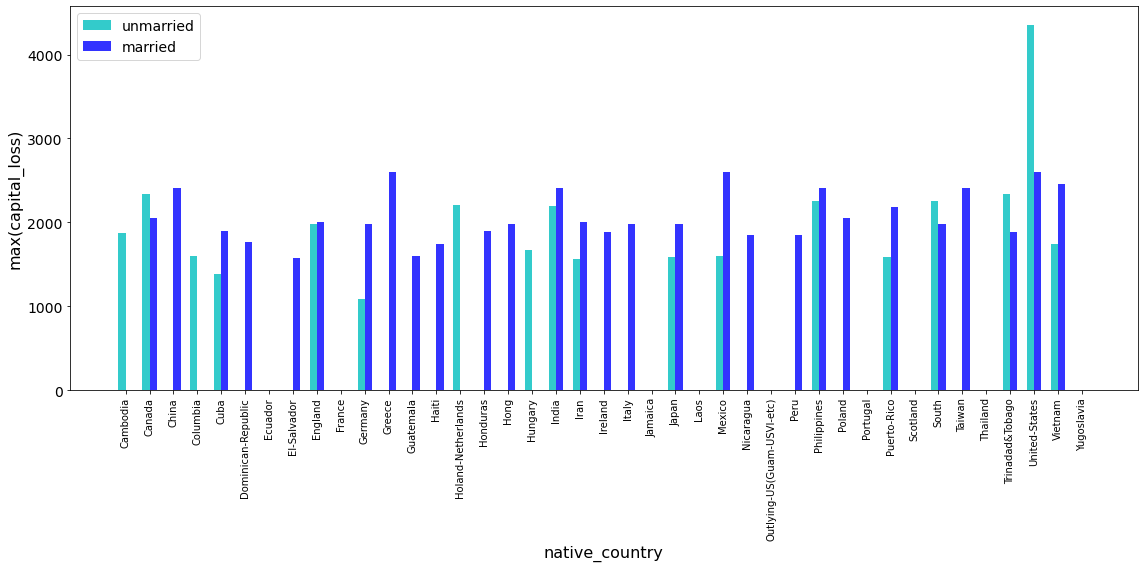

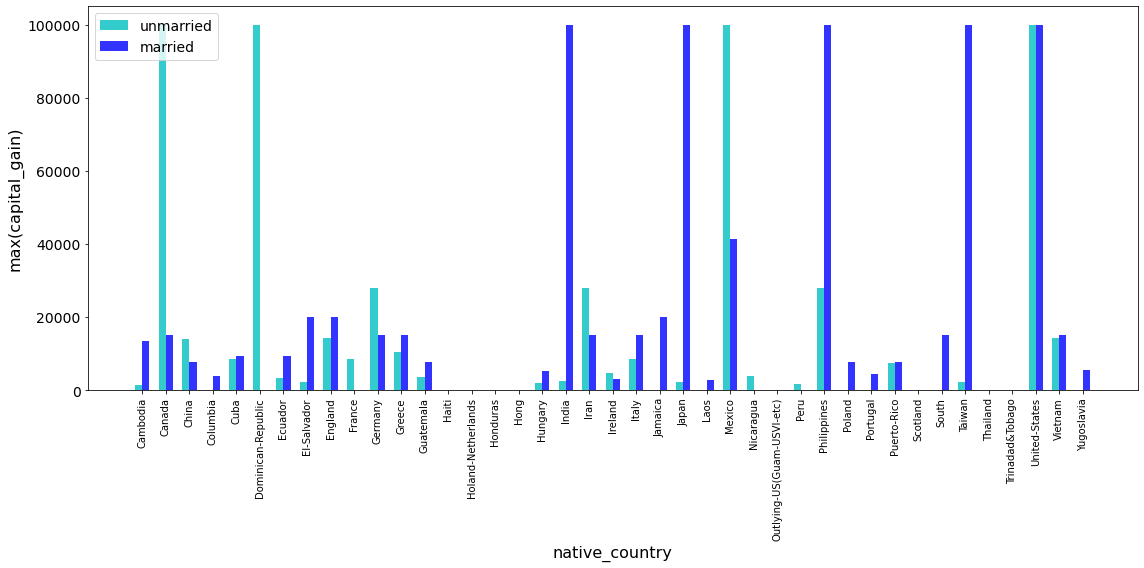

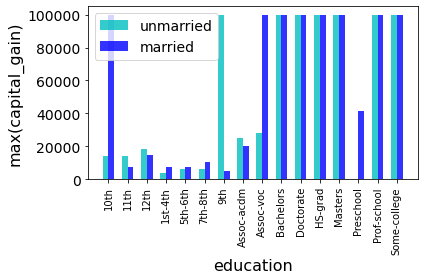

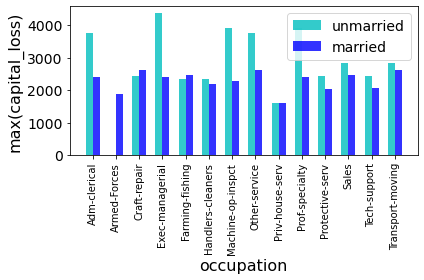

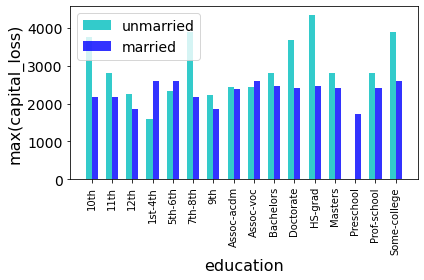

In [277]:
print(v)
draw_views(v)

In [195]:
%%time
apply_algorithms(apply_multiple_group_by=False, apply_pruning=False)

Wall time: 50.4 s


[('relationship', 'capital_gain', 'sum'),
 ('relationship', 'capital_gain', 'max'),
 ('native_country', 'capital_loss', 'max'),
 ('relationship', 'capital_loss', 'sum'),
 ('native_country', 'capital_gain', 'max')]

In [257]:
%%time
v = apply_algorithms(apply_multiple_group_by=True, apply_pruning=False)

Wall time: 44.7 s


[('native_country', 'capital_loss', 'max'), ('native_country', 'capital_gain', 'max'), ('native_country', 'capital_loss', 'min'), ('native_country', 'capital_gain', 'min'), ('education', 'capital_loss', 'max')]


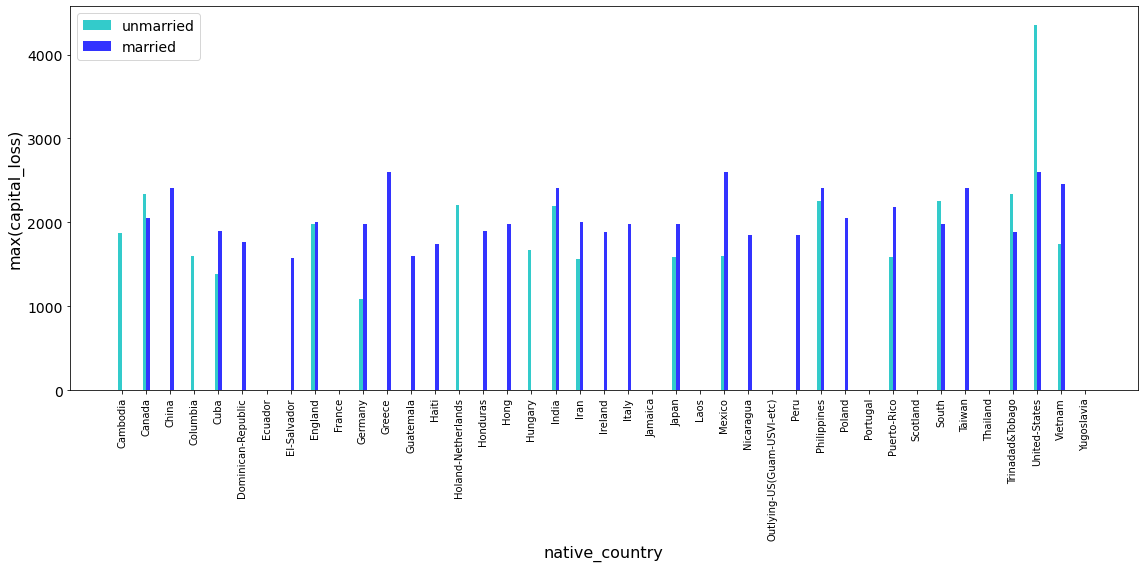

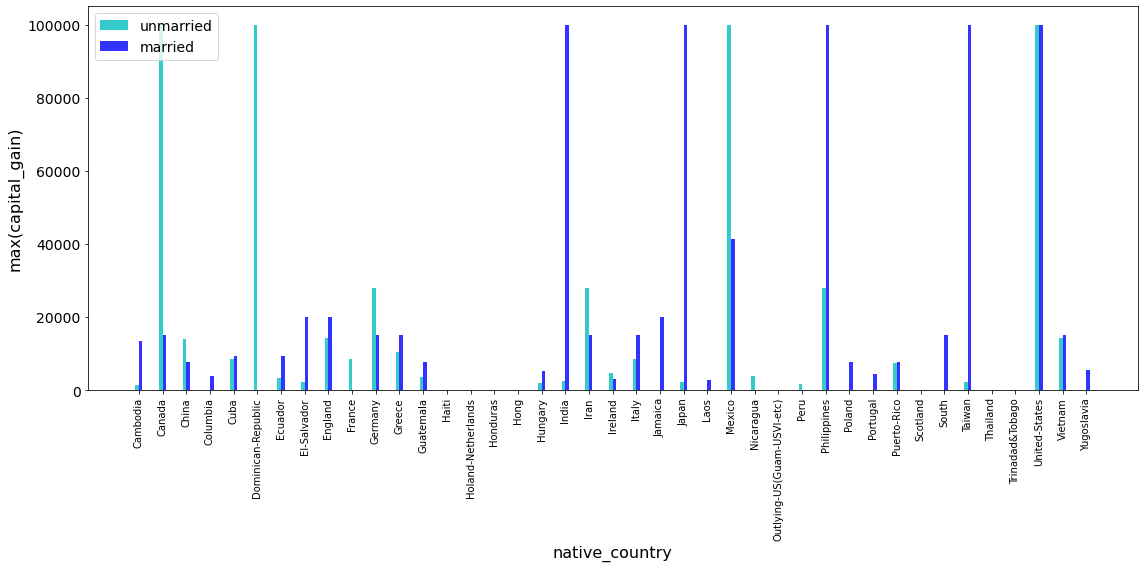

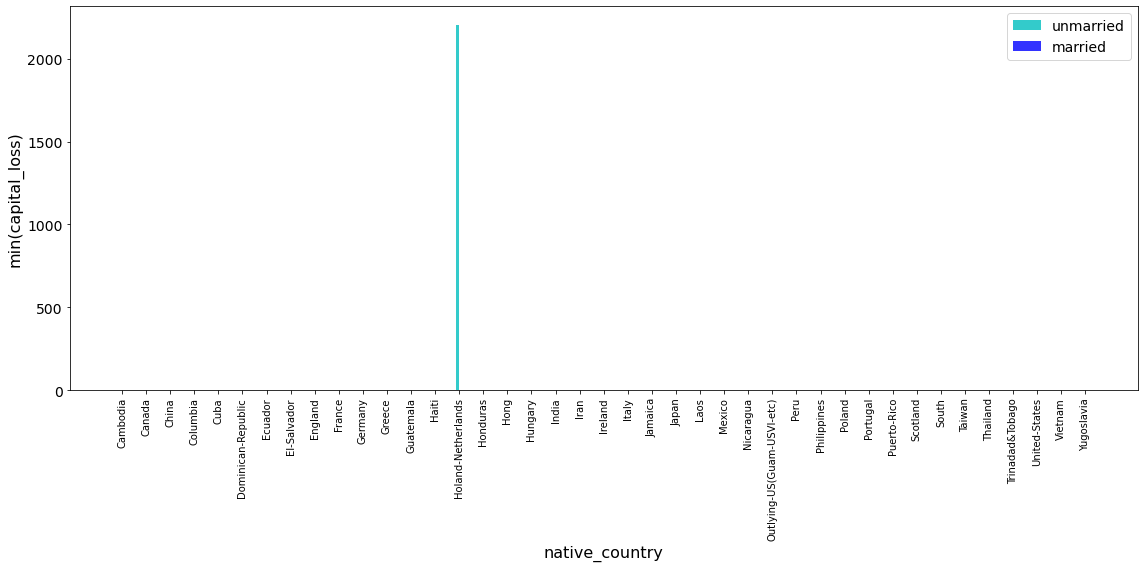

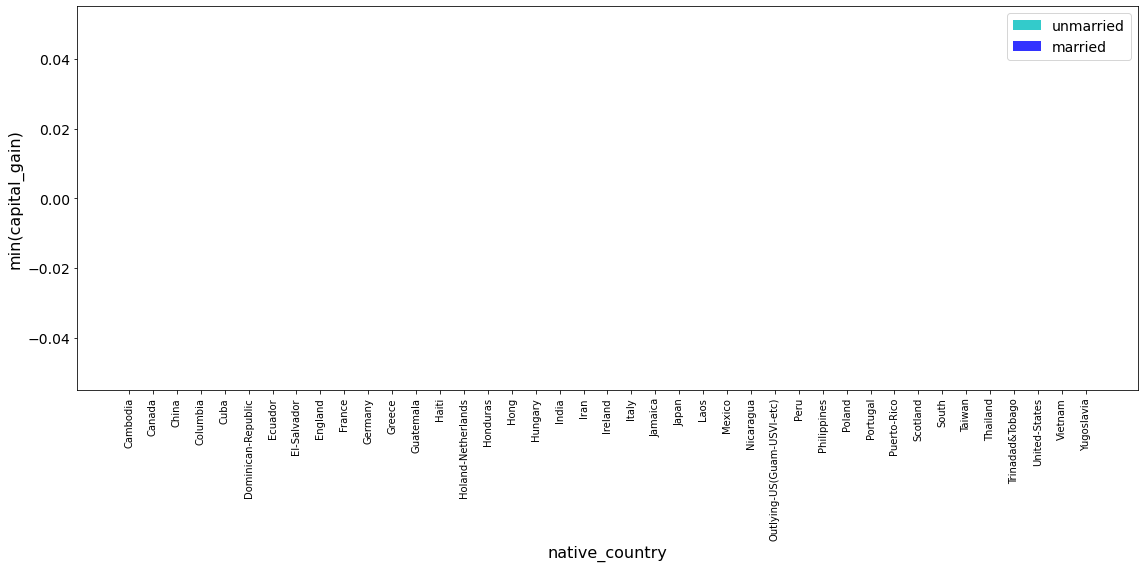

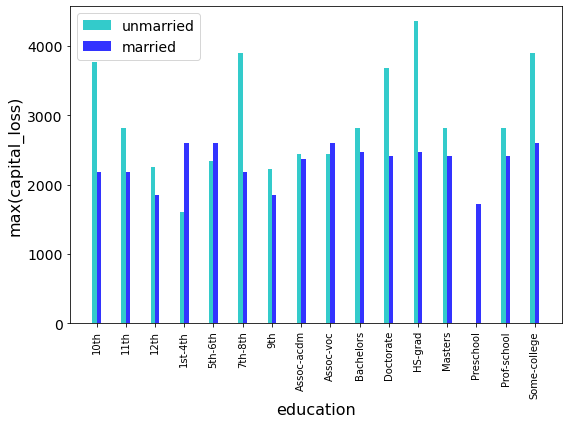

In [258]:
print(v)
draw_views(v)

In [261]:
%%time
v = apply_algorithms(apply_multiple_group_by=True, apply_pruning=True)

Wall time: 46.8 s


[('native_country', 'capital_loss', 'max'), ('native_country', 'capital_gain', 'max'), ('native_country', 'capital_loss', 'min'), ('native_country', 'capital_gain', 'min'), ('education', 'capital_loss', 'max')]


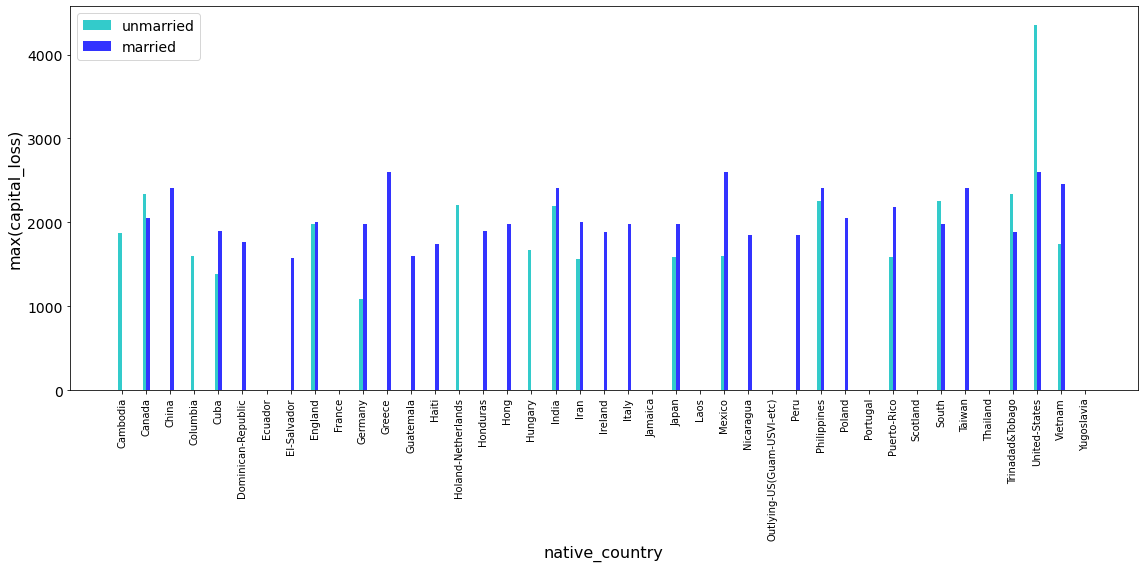

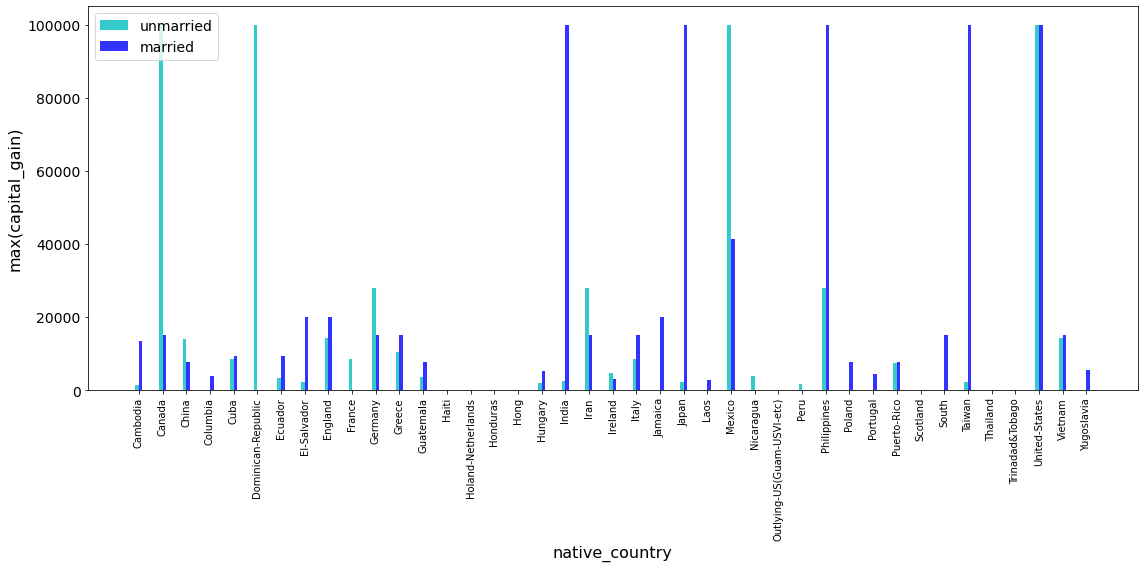

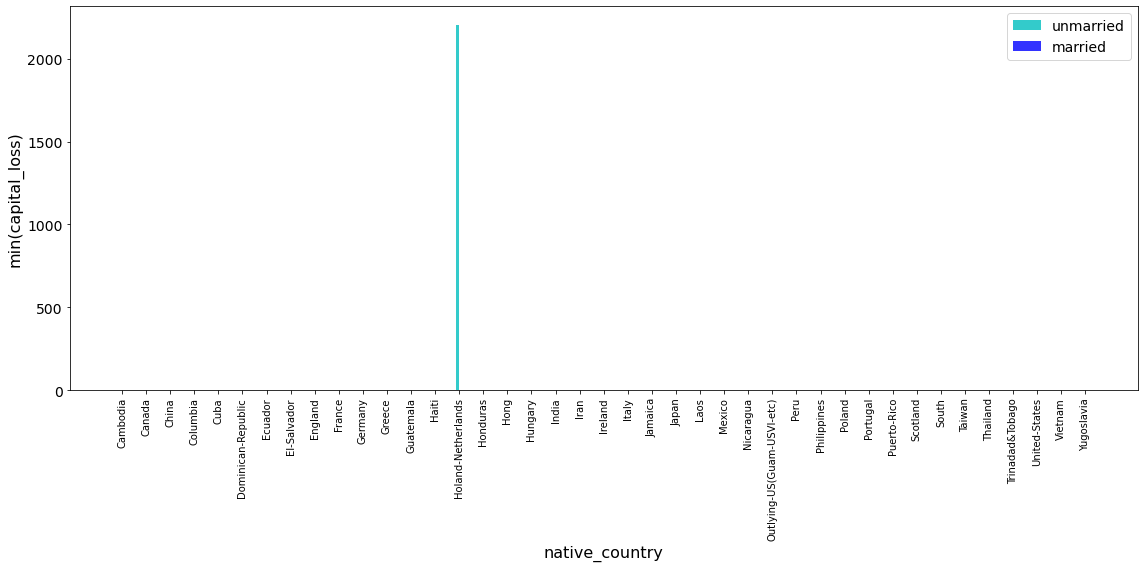

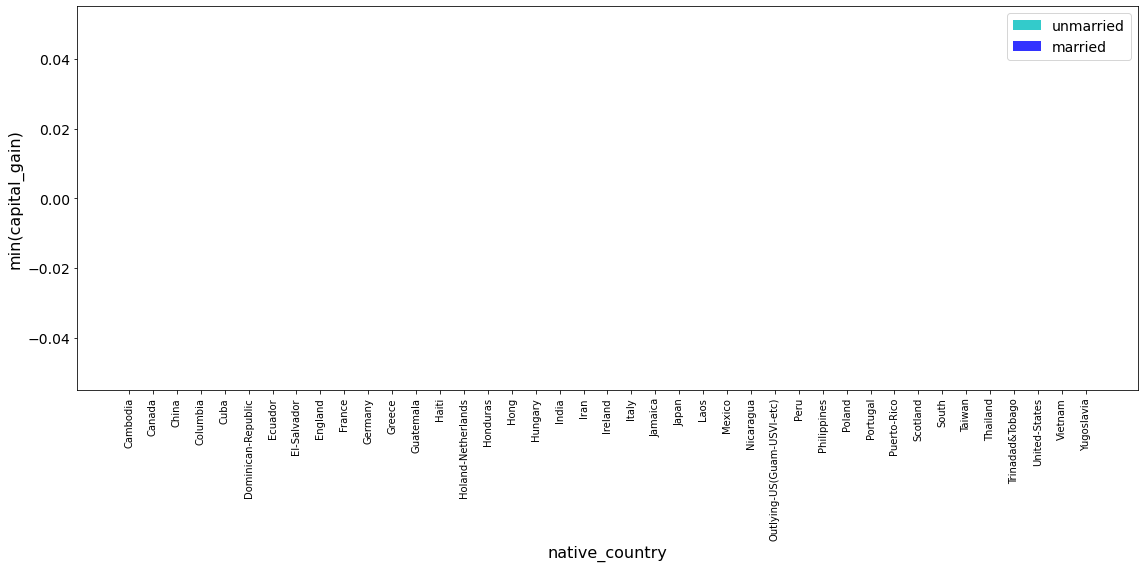

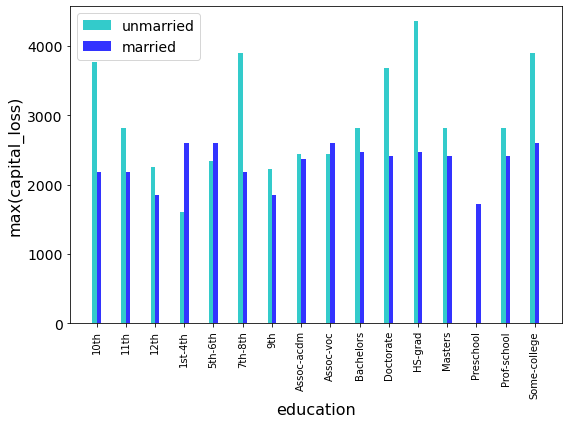

In [262]:
print(v)
draw_views(v)

In [ ]:
for s in [10, 100, 1000, 10000, 100000, 1000000, 10000000]:
    S_row = s
    print(
        "S_row = {} took {} seconds.".format(
            s, timeit.timeit(lambda: apply_algorithms(False, True), number=20)
        )
    )

### Measure time with pruning and combining GROUP BYs

In [ ]:
for s in [10, 100, 1000, 10000, 100000, 1000000, 10000000]:
    S_row = s
    print(
        "S_row = {} took {} seconds.".format(
            s, timeit.timeit(lambda: apply_algorithms(True, True), number=20)
        )
    )

In [ ]:
## TODO: create a separate cell for generating the plots and saving them.

In [ ]:
# %%time

# n_splits = 10
# split_path = Path('/content/census.splits')
# split_path.mkdir(parents=True, exist_ok=True)

# df = pd.DataFrame(pd.read_csv('/content/adultdata.csv'))
# df.columns = [i.replace('-', '_') for i in df.columns]

# df_split= np.array_split(df, n_splits)

# for i in range(len(df_split)):
#     df_split[i].to_csv(Path(split_path / "census.split_{}.csv".format(i)), encoding='utf-8', index=False)

# !zip -r /content/census.splits.zip /content/census.splits

In [ ]:
# for i in range(n_splits):
#     cur.executescript('''drop table if exists split_{};
#                         create table split_{}
#                         (age int, work_class text, fnlwgt int, education text, education_num int, marital_status text, occupation text, relationship text, 
#                         race text, sex text, capital_gain int, capital_loss int, hours_per_week int, native_country text, class text)'''.format(i, i))
    
#     # change this to psql
#     df = pd.DataFrame(pd.read_csv('/content/census.splits/census.split_{}.csv'.format(i)))
#     for row in df.itertuples():
#         cur.execute('''
#                   INSERT INTO split_{} (age, work_class, fnlwgt, education, education_num, marital_status, occupation, relationship, 
#                   race, sex, capital_gain, capital_loss, hours_per_week, native_country, class)
#                   VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
#                   '''.format(i),
#                   (row.AGE, row.WORK_CLASS, row.FNLWGT, row.EDUCATION, row.EDUCATION_NUM, row.MARITAL_STATUS, row.OCCUPATION, row.RELATIONSHIP, 
#                   row.RACE, row.SEX, row.CAPITAL_GAIN, row.CAPITAL_LOSS, row.HOURS_PER_WEEK, row.NATIVE_COUNTRY, row.CLASS)
#                   )   

# conn.commit()
# census_view_query = 'drop view if exists census_view; create view census_view as select * from split_0'
# for i in range(1, n_splits):
#     census_view_query += ' union select * from split_{}'.format(i)
# census_view_query += ';'
# cur.executescript(census_view_query)
# conn.commit()

In [ ]:
# n_phases = n_splits
# for i in range(n_phases):
#     query = """drop view if exists split_{0}_married; create view split_{0}_married as select * from split_{0} where marital_status in ('Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent','Separated');
#            drop view if exists split_{0}_unmarried; create view split_{0}_unmarried as select * from split_{0} where marital_status in ('Never-married', 'Widowed','Divorced');""".format(i)
#     cur.executescript(query)
#     conn.commit()